# Generate Use Cases

Use PyBaMM to initialize a DFN model to act as a surrogate model for a physical battery. 

Use this model to generate use cases.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybamm
import sys

sys.path.append('../')

from src import plotter as plotter
plotter.initialize(plt)



## Set up model and parameters

In [34]:
model            = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Chen2020")
solver           = pybamm.IDAKLUSolver(options={'dt_max':1})

## First simulate a 1C discharge to obtain some nominal value for cell energy

In [45]:
experiment      = pybamm.Experiment(
    ["Discharge at 1C until 2.5V"]
    )

sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=1)

time = sol["Time [s]"].data
power = sol["Power [W]"].data
energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600

nominal_energy = energy[-1]

print(f"Nominal energy: {nominal_energy:.2f} Wh")

Nominal energy: 17.50 Wh


## Use Case 1: Energy Mode

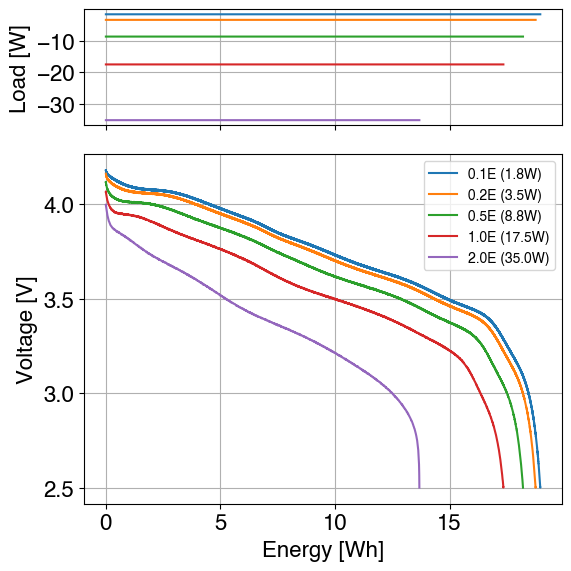

In [50]:
# Set the discharge powers to simulate

e_rate_list = np.array([0.1, 0.2, 0.5, 1.0, 2.0])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

for e_rate in e_rate_list:

    experiment = pybamm.Experiment(
        [f"Discharge at {e_rate*nominal_energy:.2f}W until 2.5V"]
        )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=1)

    time_vec = sol["Time [s]"].data
    power_vec = sol["Power [W]"].data
    voltage_vec = sol["Voltage [V]"].data

    # Add white noise to voltage output with std dev of 0.02% of FSR with 5V range
    voltage_vec = voltage_vec + np.random.normal(0, 0.0002*5, size=len(voltage_vec))
    energy_vec = np.cumsum(power_vec * np.diff(np.append(0, time_vec))) / 3600

    ax1.plot(energy_vec, -power_vec)
    ax2.plot(energy_vec, voltage_vec, label=f"{e_rate:.1f}E ({e_rate*nominal_energy:.1f}W)")

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Energy [Wh]")
ax2.legend(fontsize=10)

# Use Case 2: Power Mode

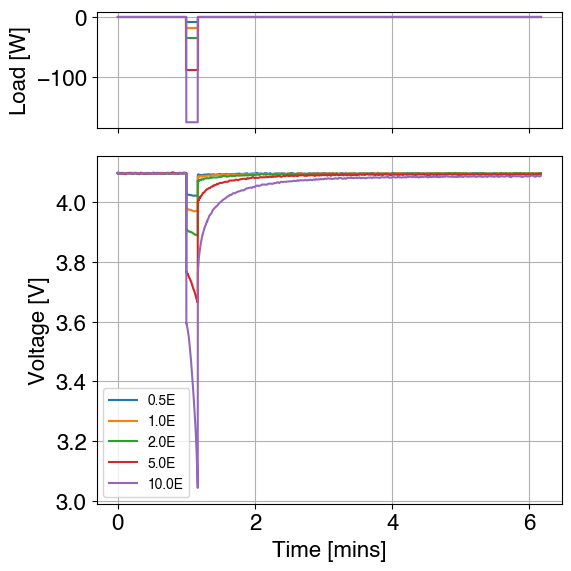

In [47]:
# Set the discharge powers to simulate
e_rate_list = np.array([0.5, 1.0, 2.0, 5.0, 10.0])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

for e_rate in e_rate_list:

    experiment = pybamm.Experiment(
        [
            "Rest for 1 minute",
            f"Discharge at {e_rate*nominal_energy:.2f} W for 10 seconds",
            "Rest for 5 minutes"
        ]
    )

    sim = pybamm.Simulation(model=model,
                            parameter_values=parameter_values,
                            experiment=experiment,
                            solver=solver)

    sol = sim.solve(initial_soc=0.9)

    time_vec = sol["Time [s]"].data
    power_vec = sol["Power [W]"].data
    voltage_vec = sol["Voltage [V]"].data

    # Add white noise to voltage output with std dev of 0.02% of FSR with 5V range
    voltage_vec = voltage_vec + np.random.normal(0, 0.0002*5, size=len(voltage_vec))
    energy_vec = np.cumsum(power_vec * np.diff(np.append(0, time_vec))) / 3600

    ax1.plot(time_vec/60, -power_vec)
    ax2.plot(time_vec/60, voltage_vec, label=f"{e_rate:.1f}E")

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")
ax2.legend(fontsize=10)

# Use Case 3: Dynamic Load Profile

2025-02-22 12:43:54.505 - [WARNING] callbacks.on_experiment_infeasible_time(240): 

	Experiment is infeasible: default duration (1851.9 seconds) was reached during 'Step([[0.0000e+00 1.9400e-01]
 [1.0000e-01 1.9400e-01]
 [2.0000e-01 1.9400e-01]
 ...
 [1.8517e+03 1.4000e-02]
 [1.8518e+03 1.4000e-02]
 [1.8519e+03 1.4000e-02]], duration=1851.9, period=0.09999999999990905, direction=Discharge)'. The returned solution only contains up to step 1 of cycle 1. Please specify a duration in the step instructions.


Text(0.5, 0, 'Time [mins]')

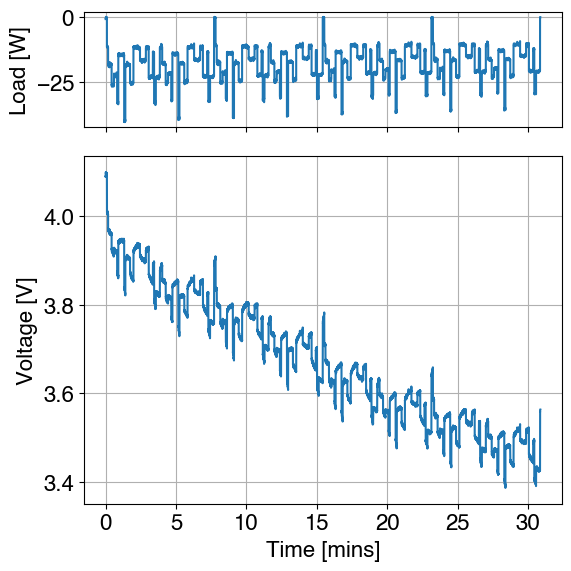

In [73]:
df = pd.read_csv("../data/load_profile_usc_dynamic.csv")

# Create copies with adjusted time
current_data1 = np.column_stack([df.time - df.time[0] + 0*df.time.iloc[-1], df.load])
current_data2 = np.column_stack([df.time - df.time[0] + 1*df.time.iloc[-1], df.load])
current_data3 = np.column_stack([df.time - df.time[0] + 2*df.time.iloc[-1], df.load])
current_data4 = np.column_stack([df.time - df.time[0] + 3*df.time.iloc[-1], df.load])

# Stack the three arrays vertically
current_data = np.vstack([current_data1, current_data2, current_data3, current_data4])

experiment = pybamm.Experiment(
    [pybamm.step.current(current_data)])


sim = pybamm.Simulation(model=model,
                        parameter_values=parameter_values,
                        experiment=experiment,
                        solver=solver)

sol = sim.solve(initial_soc=0.9)

time_vec = sol["Time [s]"].data
power_vec = sol["Power [W]"].data
voltage_vec = sol["Voltage [V]"].data

# Add white noise to voltage output with std dev of 0.02% of FSR with 5V range
voltage_vec = voltage_vec + np.random.normal(0, 0.0002*5, size=len(voltage_vec))
energy_vec = np.cumsum(power_vec * np.diff(np.append(0, time_vec))) / 3600

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])
plt.subplots_adjust(hspace=0)

ax1.plot(time_vec/60, -power_vec, c='k')
ax2.plot(time_vec/60, voltage_vec, c='k')

ax1.set_ylabel("Load [W]")
ax2.set_ylabel("Voltage [V]")
ax2.set_xlabel("Time [mins]")

# Kalman Filter Study 

1. Define current profile with noise w_u

Generate "physical asset" data using a surrogate model: DFN_P
2. Run the profile through the P2D (DFN) with the default Chen2020 parameter-set and get voltage output with noise v

Generate a surrogate model that's close to the physical asset but not quite 
3. Re-Run (2) with three adjustments to the Chen2020 parameters (simulate process noise) 
(DFN_A). Close
(DFN_B). Not great
(DFN_C). Way off

4. Tune the ECM parameters to (2).

5. Run current profile through the ECM

6. For each of case DFN_i where i = {A,B,C}:

   A. Run the open-loop study to derive:
      i. w_m based on RMSE(z_DFN_P, z_DFN_i)
      ii. w_s based on RMSE(z_DFN_i, z_ECM)
      iii. w_u based on input noise w_u
      Calculate Q = E(ww^T), where w = w_m + w_s + w_u 

   B. Run the KF for fixed Q and R using our heuristic

7. A. Build the rest of the heatmap by sweeping through values of Q and R
   B. Plot the Q and R for each of DFN_i, where i = {A,B,C}



## Sweeping C-rate

By sweeping the C-rate, we can see how the power and energy change (higher C-rate means higher power and lower energy).

In [4]:
C_rates = [0.1, 0.2, 0.5, 0.75, 1, 1.5, 2, 2.25, 2.5, 3, 3.5, 4, 5, 7.5, 10]

def sweep_c_rate(C_rates, parameter_values):
    """
    Simulates battery discharge at different C-rates and collects performance metrics.

    Parameters
    ----------
    C_rates : array-like
        List or array of C-rates to simulate discharge at
    parameter_values : pybamm.ParameterValues
        Battery model parameters

    Returns
    -------
    dict
        Dictionary containing simulation results with keys:
        - 'C-rate': Input C-rates
        - 'Energy [Wh]': Energy profiles over time for each C-rate
        - 'Discharge Energy [Wh]': Total discharge energy for each C-rate
        - 'Time [s]': Time points for each simulation
        - 'Voltage [V]': Voltage profiles over time for each C-rate
        - 'Mean Power [W]': Average power for each C-rate

    Notes
    -----
    Uses PyBaMM to simulate battery discharge from full charge (SOC=1)
    until reaching cutoff voltage of 2.5V at specified C-rates.
    Energy is calculated by integrating power over time.
    """

    outputs = {
            "C-rate": C_rates,
            "Energy [Wh]": [],
            "Discharge Energy [Wh]": [],
            "Time [s]": [],
            "Voltage [V]": [],
            "Mean Power [W]": []
            }

    for C_rate in C_rates:

        experiment = pybamm.Experiment(
            [f"Discharge at {C_rate}C until 2.5V"]
            )

        sim = pybamm.Simulation(model,
                                parameter_values=parameter_values,
                                experiment=experiment,
                                solver=solver
                                )

        sol = sim.solve(initial_soc=1)

        time = sol["Time [s]"].data
        power = sol["Power [W]"].data
        voltage = sol["Voltage [V]"].data

        energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600
        discharge_energy = energy[-1]

        outputs["Voltage [V]"].append(voltage)
        outputs["Time [s]"].append(time)
        outputs["Energy [Wh]"].append(energy)
        outputs["Discharge Energy [Wh]"].append(discharge_energy)
        outputs["Mean Power [W]"].append(np.mean(power))

    return outputs

outputs_energy_cell = sweep_c_rate(C_rates, parameter_values)

Text(0.5, 0.98, 'Energy cell')

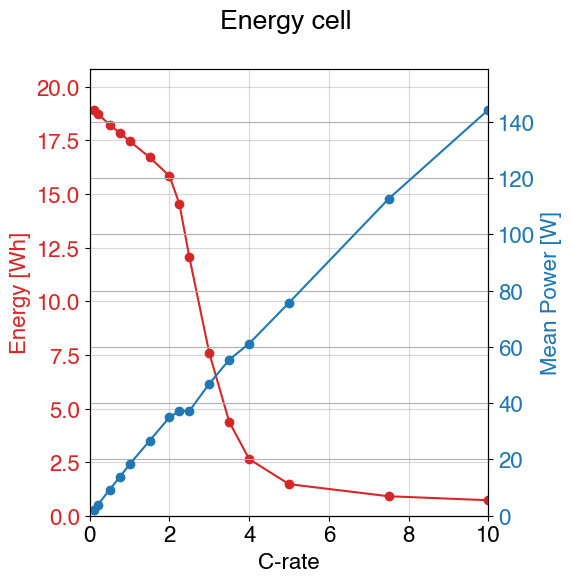

In [5]:
def plot_power_vs_energy(outputs):
    """
    Plot power and energy outputs versus C-rate with dual y-axes.
    This function creates a dual y-axis plot showing the relationship between:
    1. Discharge energy (left y-axis, red)
    2. Mean power (right y-axis, blue)
    versus C-rate (x-axis)

    Parameters
    ----------
    outputs : dict
        Dictionary containing the following keys:
        - "C-rate": array-like, C-rates for x-axis
        - "Discharge Energy [Wh]": array-like, energy values in Watt-hours
        - "Mean Power [W]": array-like, power values in Watts

    Returns
    -------
    tuple
        (fig, ax) where:
        - fig : matplotlib.figure.Figure
            The created figure object
        - ax : matplotlib.axes.Axes
            The primary axes object (energy axis)

    """

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_xlabel("C-rate")

    ax.plot(outputs["C-rate"], outputs["Discharge Energy [Wh]"], "-o", color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, outputs["Discharge Energy [Wh]"][0] * 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(outputs["C-rate"], outputs["Mean Power [W]"], "-o", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Mean Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Mean Power [W]"][-1] * 1.1)

    ax.grid(alpha=0.5)

    return fig, ax

fig, ax = plot_power_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


Text(0.5, 0.98, 'Energy cell')

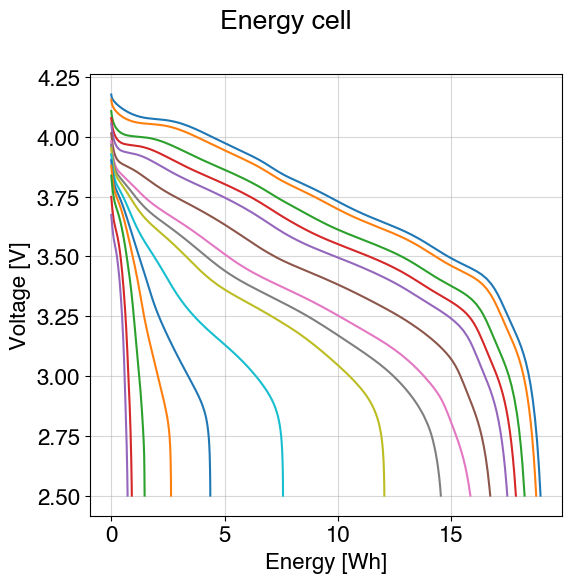

In [6]:
def plot_voltage_vs_energy(outputs):
    """
    Plot voltage vs energy curves from battery data.

    Args:
        outputs (dict): Dictionary containing voltage and energy data with keys:
            - "Voltage [V]": List/array of voltage values
            - "Energy [Wh]": List/array of energy values

    Returns:
        tuple: Contains:
            - fig (matplotlib.figure.Figure): The generated figure object
            - ax (matplotlib.axes.Axes): The axes object containing the plot

    """


    fig, ax = plt.subplots()

    for voltage, energy in zip(outputs["Voltage [V]"], outputs["Energy [Wh]"]):
        ax.plot(energy, voltage)
    ax.set_xlabel("Energy [Wh]")
    ax.set_ylabel("Voltage [V]")

    ax.grid(alpha=0.5)

    return fig, ax

fig, ax = plot_voltage_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


This is an energy cell with a maximum C-rate of 2C, so the energy drops off significantly as the C-rate increases above 2C

## Changing electrode thickness

We can also sweep the electrode thickness to see how the power and energy change. We will change the thickness of the positive electrode and the negative electrode proportionally to avoid having to change the N/P ratio and electrode balance.

Text(0.5, 0.98, 'Power cell')

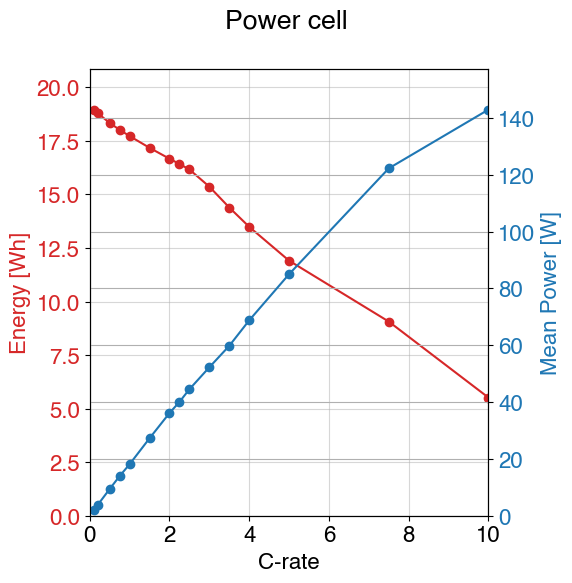

In [7]:
parameter_values_power_cell = pybamm.ParameterValues("Chen2020")
parameter_values_power_cell["Negative electrode thickness [m]"] *= 1/2
parameter_values_power_cell["Positive electrode thickness [m]"] *= 1/2
parameter_values_power_cell["Electrode height [m]"] *= 2

outputs_power_cell = sweep_c_rate(C_rates, parameter_values_power_cell)
fig, ax = plot_power_vs_energy(outputs_power_cell)
fig.suptitle("Power cell")


The power cell maintains its capacity better at higher C-rates. The downside of the power cell is that it has a lower specific energy since the ratio of active material to inactive material (current collector, separator, etc.) is higher. PyBaMM does not provide a specific energy / specific power, so you would need to define your own function for how cell mass depends on parameters to get specific energy and specific power.

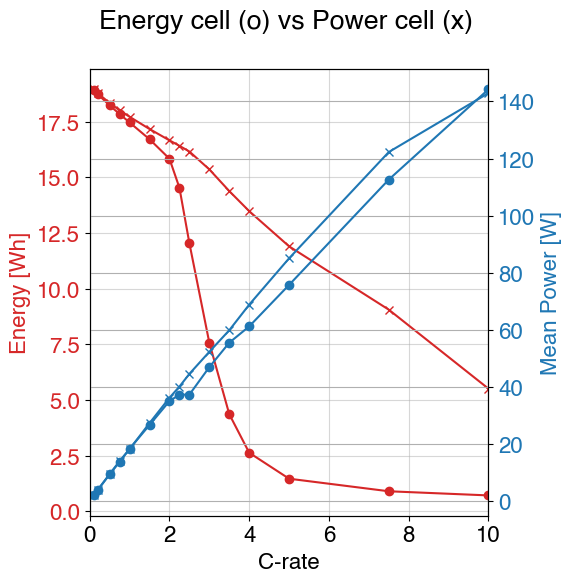

In [8]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_xlabel("C-rate")

styles = ["-o", "-x"]

for outputs, style in zip([outputs_energy_cell, outputs_power_cell], styles):

    ax.plot(outputs["C-rate"], outputs["Discharge Energy [Wh]"], style, color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")

    ax2.plot(outputs["C-rate"], outputs["Mean Power [W]"], style, color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Mean Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])

ax.grid(alpha=0.5)

fig.suptitle("Energy cell (o) vs Power cell (x)");
